In [3]:
# Необходимый импорт
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("Set2")
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgd

RUNDOM_SEED = 42

In [4]:
df = pd.read_csv('data\CreditScoring.csv')
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455 entries, 0 to 4454
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   status     4455 non-null   int64
 1   seniority  4455 non-null   int64
 2   home       4455 non-null   int64
 3   time       4455 non-null   int64
 4   age        4455 non-null   int64
 5   marital    4455 non-null   int64
 6   records    4455 non-null   int64
 7   job        4455 non-null   int64
 8   expenses   4455 non-null   int64
 9   income     4455 non-null   int64
 10  assets     4455 non-null   int64
 11  debt       4455 non-null   int64
 12  amount     4455 non-null   int64
 13  price      4455 non-null   int64
dtypes: int64(14)
memory usage: 487.4 KB


In [6]:
# Восстановим данные при помощи map

status_values = {
    1: 'ok',
    2: 'default',
    3: 'unk'
}
df['status'] = df['status'].map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df['home'] = df['home'].map(home_values)

marital_values = {
    1: 'single',
    2: 'marrier',
    3: 'widow',
    4: 'separated',
    5: 'divorsed',
    0: 'unk'
}
df['marital'] = df['marital'].map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    3: 'unk'
}
df['records'] = df['records'].map(records_values)

job_values = {
    1: 'fixed',
    2: 'parttime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
df['job'] = df['job'].map(job_values)

In [7]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,marrier,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,marrier,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [8]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [9]:
# заменим выбросы в столбцах income assets debt на Nan

for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999.0, value=np.nan)

In [10]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [11]:
# рассмотрим целевую переменную
df['status'].value_counts()

ok         3200
default    1254
Name: status, dtype: int64

## Подготовка данных

In [12]:
# Разделим данные на тренировочыне, валидационные и тестовые
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=RUNDOM_SEED)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=RUNDOM_SEED)

# Выделим целевую переменную
y_train = (df_train['status'] == 'default').values
y_val = (df_val['status'] == 'default').values

# Удалим ненужные столбцы
del df_train['status']
del df_val['status']

# заполним недостающие значения нулями
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)

In [13]:
# Закодируем переменные при помощи DictVectorizer
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

## Деревья решений

In [14]:
# обучаем модель
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [15]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train,y_pred)

0.9999996450431698

In [16]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val,y_pred)

0.6593975739403026

Модель переобучена

In [17]:
export_text

<function sklearn.tree._export.export_text(decision_tree, *, feature_names=None, max_depth=10, spacing=3, decimals=2, show_weights=False)>

In [18]:
# испарвим глубину
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_train)[:, 1]
print(f'roc auc score in train: {roc_auc_score(y_train,y_pred)}\n')

tree_text = export_text(dt, feature_names=dv.feature_names_)
print(tree_text)

roc auc score in train: 0.7783638903836515

|--- records=yes <= 0.50
|   |--- job=parttime <= 0.50
|   |   |--- income <= 83.50
|   |   |   |--- class: False
|   |   |--- income >  83.50
|   |   |   |--- class: False
|   |--- job=parttime >  0.50
|   |   |--- assets <= 8500.00
|   |   |   |--- class: True
|   |   |--- assets >  8500.00
|   |   |   |--- class: False
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- seniority <= 1.50
|   |   |   |--- class: True
|   |   |--- seniority >  1.50
|   |   |   |--- class: True
|   |--- seniority >  6.50
|   |   |--- income <= 106.00
|   |   |   |--- class: True
|   |   |--- income >  106.00
|   |   |   |--- class: False



In [19]:
y_pred = dt.predict_proba(X_val)[:, 1]
print(f'roc auc score in val: {roc_auc_score(y_val,y_pred)}')

roc auc score in val: 0.7377396012737434


### Подбор гиперпараметров дерева решений

In [20]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=depth)

    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print(f'{depth} - {auc}')

1 - 0.5989505247376311
2 - 0.6701804056649362
3 - 0.7377396012737434
4 - 0.7359089050516064
5 - 0.7506257201977524
6 - 0.7557677772683906
10 - 0.677026156343316
15 - 0.6627584967846655
20 - 0.6649175412293854
None - 0.667609377129617


In [21]:
for m in [5, 6]:
    print(f'Depth: {m}')

    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)

        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print(f'{s} - {auc}')
    print('\n')

Depth: 5
1 - 0.7506257201977524
5 - 0.7575984734905277
10 - 0.760030108912486
15 - 0.7535963423247054
20 - 0.759336240970424
50 - 0.7620683459922932
100 - 0.7633786412578836
200 - 0.7625763564498742


Depth: 6
1 - 0.7555323577880481
5 - 0.7588561091355148
10 - 0.7620931269902239
15 - 0.7606434386112729
20 - 0.7623471322190145
50 - 0.7705434472846223
100 - 0.7678516113843905
200 - 0.7628861189240091




In [22]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=50)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_val)[:, 1]
print(f'roc auc score in val: {roc_auc_score(y_val,y_pred)}')

roc auc score in val: 0.7705434472846223


## Случайный лес

In [23]:
rf = RandomForestClassifier(n_estimators=10, random_state=RUNDOM_SEED)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7744898212050999

### Подбор гмперпараметров

In [24]:
# подберем кол-во деревьев
aucs = []

for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=RUNDOM_SEED)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print(f'{i} - {auc}')

    aucs.append(auc)

10 - 0.7744898212050999
20 - 0.7851580408143035
30 - 0.7943517910466255
40 - 0.7997695367192437
50 - 0.8005036737829433
60 - 0.801336934838366
70 - 0.8027277683472314
80 - 0.8026193514812842
90 - 0.8044624382023864
100 - 0.804868227043503
110 - 0.8056054617319439
120 - 0.8063457940451262
130 - 0.8058006120906489
140 - 0.8061134721895251
150 - 0.8064635037852974
160 - 0.8064635037852974
170 - 0.807197640848997
180 - 0.8066214826471062
190 - 0.8070799311088257
200 - 0.8069962952408094


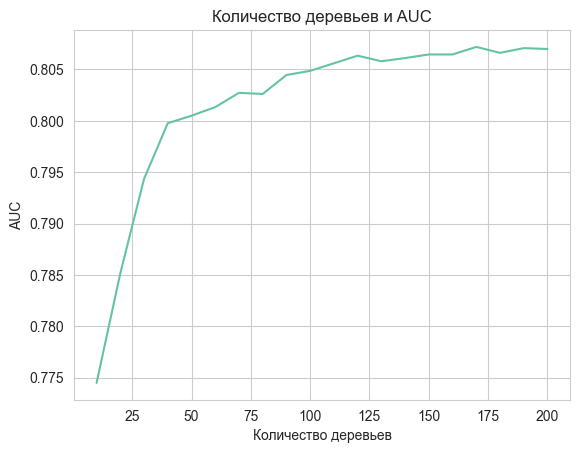

In [25]:
plt.plot(range(10,201,10), aucs)
plt.title('Количество деревьев и AUC')
plt.xlabel('Количество деревьев')
plt.ylabel('AUC')
plt.show()

In [26]:
all_aucs = {}

for depth in [5, 10, 20]:
    print(f'depth: {depth}')
    aucs = []

    for i in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=depth, random_state=RUNDOM_SEED)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print(f'{i} - {auc}')

        aucs.append(auc)

    all_aucs[depth] = aucs
    print()

depth: 5
10 - 0.7947761656361901
20 - 0.8011139058569887
30 - 0.7998376844635533
40 - 0.798998228158648
50 - 0.7968051098417734
60 - 0.7984313628309813
70 - 0.8019936312835318
80 - 0.8004138426654441
90 - 0.8001598374366534
100 - 0.7998005129666571
110 - 0.7998005129666571
120 - 0.8010829296095754
130 - 0.8012130298487121
140 - 0.8006740431437175
150 - 0.8017458213042239
160 - 0.8023095890071492
170 - 0.8025264227390436
180 - 0.8026813039761111
190 - 0.8030592141945556
200 - 0.8027680374688689

depth: 10
10 - 0.7899252852912386
20 - 0.7962227563903999
30 - 0.8013926920837102
40 - 0.8071418836036527
50 - 0.8073153505891683
60 - 0.8086535244774307
70 - 0.8091553396855292
80 - 0.8087836247165674
90 - 0.8092234874298389
100 - 0.8096943263905237
110 - 0.8103943895820683
120 - 0.8108652285427533
130 - 0.8106112233139628
140 - 0.8097191073884545
150 - 0.8102704845924145
160 - 0.8095828118998353
170 - 0.8096571548936276
180 - 0.8103076560893108
190 - 0.8110077192808555
200 - 0.8110510860272342

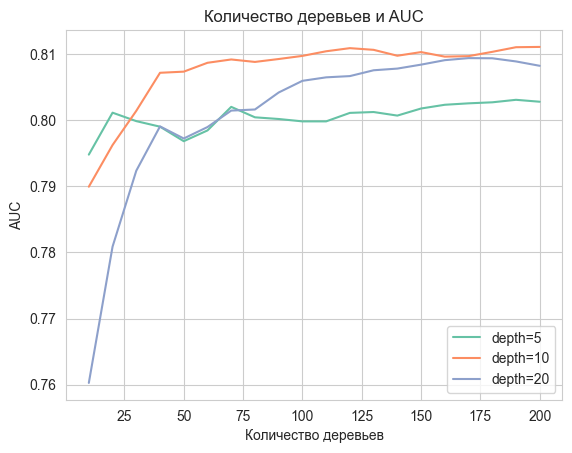

In [27]:
num_trees = list(range(10, 201, 10))
plt.plot(num_trees, all_aucs[5], label='depth=5')
plt.plot(num_trees, all_aucs[10], label='depth=10')
plt.plot(num_trees, all_aucs[20], label='depth=20')
plt.title('Количество деревьев и AUC')
plt.xlabel('Количество деревьев')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [28]:
all_aucs = {}

for m in [3, 5, 10]:
    print(f'min_samples_leaf: {m}')
    aucs = []

    for i in range(10, 201, 20):
        rf = RandomForestClassifier(n_estimators=i, max_depth=10, min_samples_leaf=m, random_state=RUNDOM_SEED)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print(f'{i} - {auc}')

        aucs.append(auc)

    all_aucs[m] = aucs
    print()

min_samples_leaf: 3
10 - 0.789857137546929
30 - 0.8010829296095755
50 - 0.8059957624493539
70 - 0.8082446380115728
90 - 0.8081393187703669
110 - 0.8098430123781084
130 - 0.8107103473056859
150 - 0.8107970807984437
170 - 0.8099297458708662
190 - 0.8098492076275912

min_samples_leaf: 5
10 - 0.7984716319526187
30 - 0.8057417572205632
50 - 0.8105926375655147
70 - 0.8126990223896315
90 - 0.8098801838750045
110 - 0.8107165425551688
130 - 0.8125255554041162
150 - 0.8124636029092892
170 - 0.8122591596763601
190 - 0.8121290594372236

min_samples_leaf: 10
10 - 0.8039823063674774
30 - 0.8093226114215619
50 - 0.8113980199982653
70 - 0.812506969655668
90 - 0.8126928271401488
110 - 0.8118750542084329
130 - 0.8111378195199921
150 - 0.8116458299775731
170 - 0.8120113496970524
190 - 0.8122467691773948



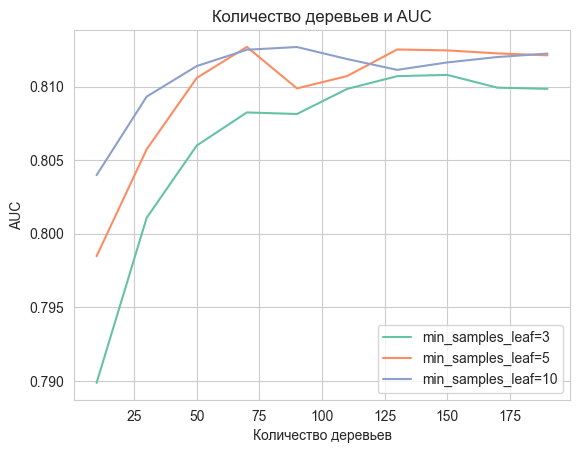

In [29]:
num_trees = list(range(10, 201, 20))
plt.plot(num_trees, all_aucs[3], label='min_samples_leaf=3')
plt.plot(num_trees, all_aucs[5], label='min_samples_leaf=5')
plt.plot(num_trees, all_aucs[10], label='min_samples_leaf=10')
plt.title('Количество деревьев и AUC')
plt.xlabel('Количество деревьев')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [30]:
# обучаем итоговую модель
rf = RandomForestClassifier(n_estimators=200, max_depth=10,
                            min_samples_leaf=5, random_state=RUNDOM_SEED)

In [31]:
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

print(auc)

0.8121786214330852


## Градиентный бустинг

In [32]:
dtrain = xgd.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgd.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

In [42]:
# указываем параметыр для обучения
xgb_parms = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': RUNDOM_SEED,
    'silent': 1
}

In [43]:
xgb_model = xgd.train(xgb_parms, dtrain, num_boost_round=10)

c:\Users\grida\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [44]:
y_pred = xgb_model.predict(dval)
roc_auc_score(y_val, y_pred)

0.803684934392308

In [ ]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_model = xgd.train(xgb_parms, dtrain, num_boost_round=100,
                      evals=watchlist, verbose_eval=10)

[0]	train-auc:0.87076	val-auc:0.72642
[10]	train-auc:0.95086	val-auc:0.80123
[20]	train-auc:0.97419	val-auc:0.79581
[30]	train-auc:0.98802	val-auc:0.79173
[40]	train-auc:0.99422	val-auc:0.79069
[50]	train-auc:0.99745	val-auc:0.78971
[60]	train-auc:0.99892	val-auc:0.79187
[70]	train-auc:0.99954	val-auc:0.79071
[80]	train-auc:0.99983	val-auc:0.78929
[90]	train-auc:0.99994	val-auc:0.78989
[99]	train-auc:0.99999	val-auc:0.78888


c:\Users\grida\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


### Настройка паремтров

In [ ]:
# изменим eta
xgb_parms = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': RUNDOM_SEED,
    'silent': 1
}

watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_model = xgd.train(xgb_parms, dtrain, num_boost_round=500,
                      evals=watchlist, verbose_eval=10)

[0]	train-auc:0.87076	val-auc:0.72642
[10]	train-auc:0.92238	val-auc:0.79417
[20]	train-auc:0.94217	val-auc:0.80638
[30]	train-auc:0.95423	val-auc:0.81019
[40]	train-auc:0.96238	val-auc:0.81249
[50]	train-auc:0.96919	val-auc:0.81373


c:\Users\grida\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[60]	train-auc:0.97443	val-auc:0.81297
[70]	train-auc:0.97779	val-auc:0.81127
[80]	train-auc:0.98184	val-auc:0.81048
[90]	train-auc:0.98556	val-auc:0.81084
[100]	train-auc:0.98815	val-auc:0.80819
[110]	train-auc:0.99045	val-auc:0.80675
[120]	train-auc:0.99278	val-auc:0.80482
[130]	train-auc:0.99434	val-auc:0.80430
[140]	train-auc:0.99561	val-auc:0.80331
[150]	train-auc:0.99649	val-auc:0.80314
[160]	train-auc:0.99741	val-auc:0.80223
[170]	train-auc:0.99810	val-auc:0.80241
[180]	train-auc:0.99866	val-auc:0.80164
[190]	train-auc:0.99896	val-auc:0.80118
[200]	train-auc:0.99919	val-auc:0.80058
[210]	train-auc:0.99942	val-auc:0.80100
[220]	train-auc:0.99950	val-auc:0.80046
[230]	train-auc:0.99957	val-auc:0.80002
[240]	train-auc:0.99967	val-auc:0.79921
[250]	train-auc:0.99976	val-auc:0.79831
[260]	train-auc:0.99982	val-auc:0.79861
[270]	train-auc:0.99988	val-auc:0.79805
[280]	train-auc:0.99991	val-auc:0.79746
[290]	train-auc:0.99995	val-auc:0.79733
[300]	train-auc:0.99997	val-auc:0.79701
[310